# Within-LH segment class analysis

Here, we compare labelled predictors to the projection to determine the extent to which they can describe distribution of data. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

In [2]:
import avgn

In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, FIGURE_DIR, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.utils.general import save_fig
from avgn.visualization.projections import scatter_spec

In [4]:
from scipy.stats import kruskal

In [5]:
from sklearn.metrics import silhouette_score, silhouette_samples

In [6]:
DATASET_ID = "git_repos"

In [7]:
DT_ID = '2022-03-04_18-41-29'

In [8]:
seg_df = pd.read_pickle(DATA_DIR / DATASET_ID / 'LH' /  'LH.pickle')
seg_df[:3]

,start_time,end_time,ID,labels,indv,indvi,filename,group,location,sex,...,simp,combi_lab_simp,call_lab_simp,call_label,seg_pos_call,call_unique_num,combi_label,seg_pos_combi,call_pos_combi,combi_unique_num
5,0.980101,1.367130,5,LH,MGGY,0,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,...,2,DS-SH-DS SH-LH,SH-LH,SHSHLH,2,1,DSSHDS SHSHLH,5,1,0
8,1.482080,1.984961,8,HL,MGGY,0,BWY MGGY Call Combo 1 300719 AM,BWYa,CRAWLEY,F,...,2,DS SH-LH,SH-LH,USC,1,3,DS USC,2,1,1
12,1.471596,1.897371,12,LH,MGGY,0,BWY MGGY Discrete 1 300719 AM,BWYa,CRAWLEY,F,...,2,DS-SH-DS LH,LH,LH,0,5,DSSHDS LH,3,1,2


In [9]:
len(seg_df)

203

In [10]:
seg_df.sort_values(by=['ID'], inplace=True)

### Spectrograms for all individuals

In [9]:
def norm(x):
    return (x-np.min(x)) / (np.max(x) - np.min(x))

In [10]:
seg_df = seg_df[np.array([np.sum(i) > 0.0 for i in seg_df.specs.values])
]

In [11]:
specs = list(seg_df.specs.values)
specs = [norm(i) for i in tqdm(specs)]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

  0%|          | 0/203 [00:00<?, ?it/s]

(203, 4096)

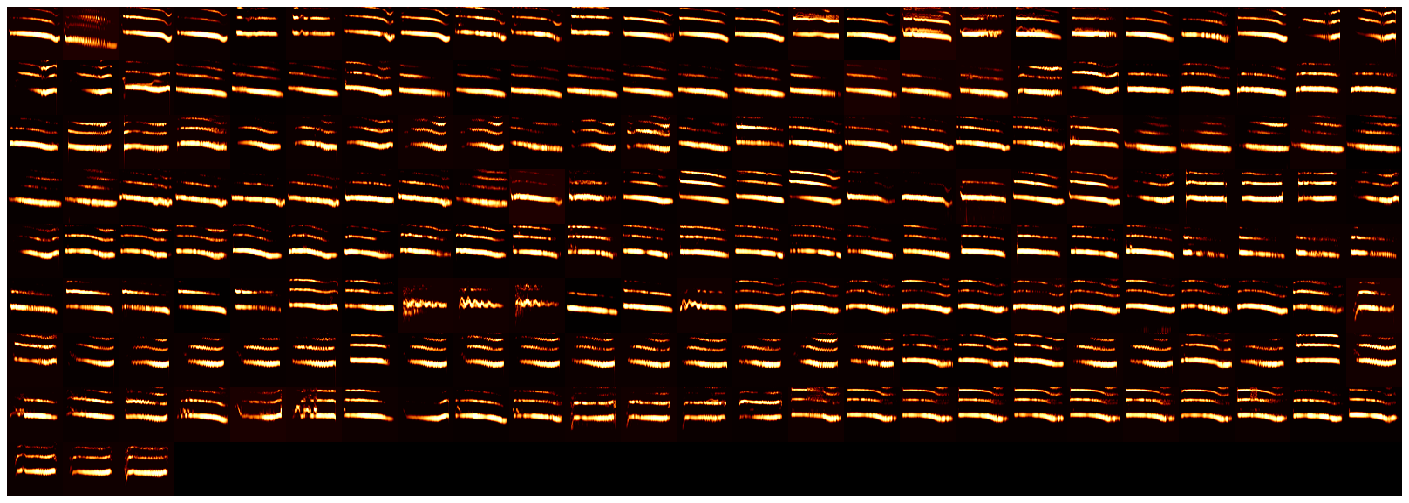

In [12]:
draw_spec_set(specs, zoom=1, maxrows=10, colsize=25)

### Create new variable

Creating a new variable to describe two categories of LH segment:
- those that solely comprise the call-level vocal unit or that are positioned last in the arrangement of segments comprising a call-level unit
- those preceding a DS segment within a call-level vocal unit

In [13]:
## create a new column of copied call label data so that I can modify
seg_df['simp'] = seg_df['call_lab_simp']
seg_df.simp.unique()

array(['SH-LH', 'LH', 'LH-DS', 'SH-DS-SH-LH', 'SH-DS-LH', 'SH-LH-DS',
       'DS-SH-DS-SH-LH'], dtype=object)

In [14]:
## Create conditions for all labels 
cond1 = seg_df['simp'] == 'SH-LH'
cond2 = seg_df['simp'] == 'LH'
cond3 = seg_df['simp'] == 'LH-DS'
cond4 = seg_df['simp'] == 'SH-DS-SH-LH'
cond5 = seg_df['simp'] == 'SH-DS-LH'
cond6 = seg_df['simp'] == 'SH-LH-DS'
cond7 = seg_df['simp'] == 'DS-SH-DS-SH-LH'

In [15]:
### Modify
seg_df.loc[cond1, 'simp'] = 'LH_LoneOrLast'
seg_df.loc[cond2, 'simp'] = 'LH_LoneOrLast'
seg_df.loc[cond3, 'simp'] = 'LH Precede DS'
seg_df.loc[cond4, 'simp'] = 'LH_LoneOrLast'
seg_df.loc[cond5, 'simp'] = 'LH_LoneOrLast'
seg_df.loc[cond6, 'simp'] = 'LH Precede DS'
seg_df.loc[cond7, 'simp'] = 'LH_LoneOrLast'

In [ ]:
nex = -1
scatter_spec(
    np.array(list(seg_df['umap'].values)),
    specs,
    column_size=10,
    #x_range = [-7,6],
    #y_range = [1,14],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': seg_df.simp.values,
        'alpha':1,
        's': 10,
        'show_legend': True,
        "color_palette": 'colorblind',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':0.5,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,
    

);

In [ ]:
nex = -1
scatter_spec(
    np.array(list(seg_df['umap'].values)),
    specs,
    column_size=10,
    #x_range = [-7,6],
    #y_range = [1,14],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': seg_df.location.values,
        'alpha':1,
        's': 10,
        'show_legend': True,
        "color_palette": 'colorblind',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':0.5,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,
    

);

In [ ]:
nex = -1
scatter_spec(
    np.array(list(seg_df['umap'].values)),
    specs,
    column_size=12,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(20, 20),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': seg_df.indv.values,
        'alpha':1,
        's': 8,
        'show_legend': True,
        "color_palette": 'plasma',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,
    

);


In [ ]:
nex = -1
scatter_spec(
    np.array(list(seg_df['umap'].values)),
    specs,
    column_size=12,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(20, 20),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': seg_df.group.values,
        'alpha':1,
        's': 8,
        'show_legend': True,
        "color_palette": 'viridis',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,
    

);

In [ ]:
nex = -1
scatter_spec(
    np.array(list(seg_df['umap'].values)),
    specs,
    column_size=12,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': seg_df.location.values,
        'alpha':1,
        's': 8,
        'show_legend': True,
        "color_palette": 'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,
    

);

In [ ]:
nex = -1
scatter_spec(
    np.array(list(seg_df['umap'].values)),
    specs,
    column_size=12,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': seg_df.call_lab_simp.values,
        'alpha':1,
        's': 10,
        'show_legend': True,
        "color_palette": 'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,
    

);

In [ ]:
nex = -1
scatter_spec(
    np.array(list(seg_df['umap'].values)),
    specs,
    column_size=10,
    #x_range = [-7,6],
    #y_range = [1,14],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': seg_df.call_lab_simp.values,
        'alpha':1,
        's': 10,
        'show_legend': True,
        "color_palette": 'colorblind',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':0.5,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,
    

);

In [ ]:
nex = -1
scatter_spec(
    np.array(list(seg_df['umap'].values)),
    specs,
    column_size=10,
    #x_range = [-7,6],
    #y_range = [1,14],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': seg_df.seg_pos_call.values,
        'alpha':1,
        's': 10,
        'show_legend': True,
        "color_palette": 'colorblind',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':0.5,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,
    

);


In [ ]:
nex = -1
scatter_spec(
    np.array(list(seg_df['umap'].values)),
    specs,
    column_size=10,
    #x_range = [-7,6],
    #y_range = [1,14],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': seg_df.simp.values,
        'alpha':1,
        's': 10,
        'show_legend': True,
        "color_palette": 'colorblind',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':0.5,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,
    

);


In [32]:
indvscore = silhouette_score(list(np.array(list(seg_df['umap'].values))), labels = seg_df.indv.values)
groupscore = silhouette_score(list(np.array(list(seg_df['umap'].values))), labels = seg_df.group.values)
locscore = silhouette_score(list(np.array(list(seg_df['umap'].values))), labels = seg_df.location.values)
sexscore = silhouette_score(list(np.array(list(seg_df['umap'].values))), labels = seg_df.sex.values)
callscore = silhouette_score(list(np.array(list(seg_df['umap'].values))), labels = seg_df.call_lab_simp.values)
posscore = silhouette_score(list(np.array(list(seg_df['umap'].values))), labels = seg_df.seg_pos_call.values)
simpscore = silhouette_score(list(np.array(list(seg_df['umap'].values))), labels = seg_df.simp.values)

In [ ]:
segmentdata = {'Test Result': ['S'], 'Indv': [indvscore],'Group': [groupscore], 'Study Site':[locscore], 'Sex':[sexscore], 'Call Label':[callscore], 'Segment Position':[posscore], 'Simp':simpscore}
df = pd.DataFrame(segmentdata)
df

In [37]:
samples = silhouette_samples(list(np.array(list(seg_df['umap'].values))), labels = seg_df.indv.values)
chance_samples = silhouette_samples(list(np.array(list(seg_df['umap'].values))), labels = np.random.permutation(seg_df.indv.values))

In [ ]:
KWindv = kruskal(samples, chance_samples)
KWindv

In [39]:
samples = silhouette_samples(list(np.array(list(seg_df['umap'].values))), labels = seg_df.group.values)
chance_samples = silhouette_samples(list(np.array(list(seg_df['umap'].values))), labels = np.random.permutation(seg_df.group.values))

In [ ]:
KWgroup = kruskal(samples, chance_samples)
KWgroup

In [41]:
samples = silhouette_samples(list(np.array(list(seg_df['umap'].values))), labels = seg_df.location.values)
chance_samples = silhouette_samples(list(np.array(list(seg_df['umap'].values))), labels = np.random.permutation(seg_df.location.values))

In [ ]:
KWloc = kruskal(samples, chance_samples)
KWloc

In [50]:
samples = silhouette_samples(list(np.array(list(seg_df['umap'].values))), labels = seg_df.sex.values)
chance_samples = silhouette_samples(list(np.array(list(seg_df['umap'].values))), labels = np.random.permutation(seg_df.sex.values))

In [ ]:
KWsex = kruskal(samples, chance_samples)
KWsex

In [52]:
samples = silhouette_samples(list(np.array(list(seg_df['umap'].values))), labels = seg_df.call_lab_simp.values)
chance_samples = silhouette_samples(list(np.array(list(seg_df['umap'].values))), labels = np.random.permutation(seg_df.call_lab_simp.values))

In [ ]:
KWcall = kruskal(samples, chance_samples)
KWcall

In [56]:
samples = silhouette_samples(list(np.array(list(seg_df['umap'].values))), labels = seg_df.seg_pos_call.values)
chance_samples = silhouette_samples(list(np.array(list(seg_df['umap'].values))), labels = np.random.permutation(seg_df.seg_pos_call.values))

In [ ]:
KWpos = kruskal(samples, chance_samples)
KWpos

In [54]:
samples = silhouette_samples(list(np.array(list(seg_df['umap'].values))), labels = seg_df.simp.values)
chance_samples = silhouette_samples(list(np.array(list(seg_df['umap'].values))), labels = np.random.permutation(seg_df.simp.values))

In [ ]:
KWsimp = kruskal(samples, chance_samples)
KWsimp

In [ ]:
segmentdata = {'Test Result': ['S', 'H_stat', 'H_pval'], 'Indv': [indvscore, KWindv.statistic, KWindv.pvalue],
               'Group': [groupscore, KWgroup.statistic, KWgroup.pvalue], 'Study Site':[locscore, KWloc.statistic, KWloc.pvalue], 
               'Sex':[sexscore, KWsex.statistic, KWsex.pvalue], 'Call Label':[callscore, KWcall.statistic, KWcall.pvalue], 
               'Segment Position':[posscore, KWpos.statistic, KWpos.pvalue], 'Simp':[simpscore, KWsimp.statistic, KWsimp.pvalue]}
df = pd.DataFrame(segmentdata)
df

In [64]:
#save df
save_loc = DATA_DIR / DATASET_ID / 'LH' /  'LH.pickle'
ensure_dir(save_loc.as_posix())
seg_df.to_pickle(save_loc)